<a href="https://colab.research.google.com/github/karthik18495/sample/blob/master/XGBOOST_for_a_simple_toy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Here is a toy model that is developed to illustrate the idea on how to clusterize using XGBoost. This might give a analogy to the actual objective



##Objective Question

To clusterize a shower from a noisy image. Look below for the example.

* First we take a clean image and then add random noise to it.
* Make the maximum intensity point as a seed and then start looking into all the pixel
* now we take every pixel in the image and compare it with various features namely
* PIXEL_VALUE, Distance_from_the_seed,del_x,del_y,energy_difference between it and the seed.
* Make a binary classifer which will return 1 if the pixel belongs to the cluster 0 if it doesnt.

#Function explanations:
## fill_matrix(int num_shower)
* Generates a image with blobs (circular for now can be changed to ellipsoidal) 
* It takes one argument, the number of showers to generate. 
* returns a matrix (2d_array)
### Procedure for generation of blobs 
* choose 2 random numbers between 5 and 20 (thats what the function random_number does). This is the seed to start creating the blob.
* Choose a random radius for the blob (a random number between 3 to 10)
* Now populate the nearbouring pixel within the radius defined by the variable `radius` in the code.
* The pixel values follows a simple 2d-gaussian function in space centred at the seed and with a spread equal to the variable `radius`.
.
* if the argument to the fill_matrix no of showes is greater than 1 then, generate another seed which is atleast 5 pixel away from the first one, and then repeat the procedure again
## add_Noise(2d_array image)
* Takes a 2d_array as an argument, it adds random noises to the image.
* It randomly adds a number from 0 to 50 (1/3 of the maximum value to the seed) to every pixel in the image.
* returns a 2d_array with noise hits

## feature_extraction(2d_array image,2d_array image_noisy) (currently not used)
* It takes in 2 parameters both being a 2d array one which is the image without adding noise the other one which is noisy. 
* It first NORMALISES the image by a simple division of maximum pixel value.It records the maximum pixel value, the location of the maximum pixel value.
* It runs through every pixel in the image and pulls out a couple of features. Currently it pulls out the pixel value at that pixel the difference in the pixel value, the radial distance between the pixel and the seed pixel, difference in the x and y direction of the pixel and the seed energy.
* there are a total of the 5 features that will get returned, There will be a dicussion in this document later as to some extra features that will be added 

## data_gen(int sample_size,int number_showers)
* it takes in total number of samples you want to generate and the number of showers in the image.
* it does the same as feature extraction 
* It also returns another list y_output which is a list of binaries (0 or 1) it returns 1 if the pixel is a part of the cluster or 0 if thepixel is not a part of the cluster.
* It returns 4 sets of lists. One the feature set which has the features of the each pixel in the image and then their corresonding binary output which says 1 or 0. a list which has pure images and a list which has noisy image.


The Above picture is a noisy representation of one cluster. We need to pick out first number of clusters from this image. But how? One way to do it is through a houghs transform and pickout ellipses from here, for actual detector hits we can use complex hough transform methods to pick out rough shapes and then make a seed for every cluster and perform a multiclass classification using BDT.


 Below is a classifer that will take in pixel by pixel of a image and returns 1 if it is a part of the cluster or 0 if it is not
 
 
 ### Feature sets for the points 
 * Pixel value -> E 
 * Difference between the pixel value and seed value ->del_E
 * radial distance between seed pixel and the current pixel->del_r
 * difference in x between seed pixel and current pixel->del_x
 * difference in y between seed pixel and current pixel->del_y
 * ratio of energy neighbouring cell and the seed_E
 
 ### Possible feature variables
  * Still Working on this

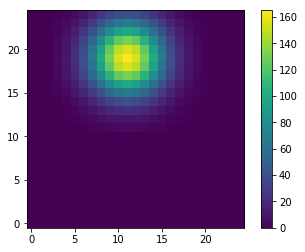

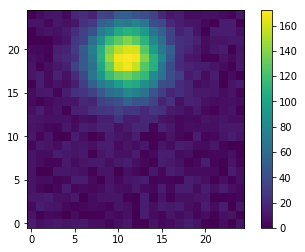

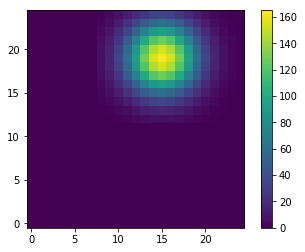

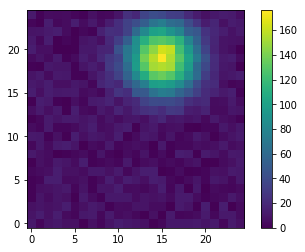

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random as rand
import math
from keras.models import Sequential

def random_number():
    seed_i = rand.randint(5,20)
    seed_j = rand.randint(5,20)
    return seed_i,seed_j

def fill_matrix(shower_size):# this will create an image (25X25) and fill it with blobs. Number of blobs are given as an argument 
    seed_i_l = []
    seed_j_l = []
    random = rand.randint(0,3)
    #print(random)
    m = np.zeros((25,25),dtype=float)
    for k in range(1,shower_size+1):
        seed_i = rand.randint(5,20)
        seed_j = rand.randint(5,20)
        radius = rand.randint(3,10)
        seed_i_l.append(seed_i)
        seed_j_l.append(seed_j)
        if(k>1):
            count = 1
            while(abs(seed_i_l[count]-seed_i_l[count-1])<10 and abs(seed_j_l[count]-seed_j_l[count-1])<10):
                print("processing.........")
                count+=1
                seed_i,seed_j = random_number()  
                seed_i_l.append(seed_i)
                seed_j_l.append(seed_j)
        seed_E1 = 15*rand.randint(10,15)
        for i in range(-1*radius,radius):
            for j in range(-1*radius,radius):
                placei_low = seed_i-radius
                placei_high = seed_i+radius
                placej_low = seed_j-radius
                placej_high = seed_j+radius
                if((seed_i-i)>0 and (seed_i-i)<25 and (seed_j-j)>0 and (seed_j-j)<25):
                    m[seed_i-i][seed_j-j]+=seed_E1*(np.exp(-0.5*(i)**2/radius-0.5*(j)**2/radius))#pixel values are determined by this formula, a simple gaussian profile for now
                    if(k>10):
                        #m[placei][placej]=15*(radius-(seed_i-i)**2-(seed_j-j)**2)**2
                        m[seed_i-i][seed_j-j]+=rand.gauss(seed_E1/10,seed_E1/20)
                    #mean=m[seed_i-i][seed_j-j]
                    #m[seed_i-i][seed_j-j]+=rand.gauss(30,30/2)
    return m

  
def add_Noise(matrix):
  matrix1 = matrix
  for i in range(len(matrix1)):
    for j in range(len(matrix1[i])):
         matrix1[i][j]+= rand.randrange(0,15)
  return matrix1

def feature_extraction(matrix,matrix_noise):
  alist=[]
  #y_output=[]
  #matrix = matrix/np.max(matrix)
  matrix_noise1 = matrix_noise1/np.max(matrix_noise1)
  seed_E = 1
  seed_x,seed_y = np.where(matrix_noise1==1)
  seed_x = int(seed_x)
  seed_y = int(seed_y)
  for i in range(len(matrix_noise)):
    for j in range(len(matrix_noise[i])):
      pos_i = i
      pos_j = j
      E = matrix_noise1[i][j]
      del_x = abs(i-seed_x)
      del_y = abs(j-seed_y)
      del_r = math.sqrt((i-seed_x)**2+(j-seed_y)**2)
      del_E = abs(matrix_noise[i][j]-seed_E)
      feature.append([pos_i,pos_j,E,del_x,del_y,del_r,del_E])
   #   if(matrix[i][j]<=5):
   #     output=0
   #   if(matrix[i][j]>5):
   #     output=1
   #   y_output.append(output)
  return alist



sample_size = 5
def data_gen(sample_size,number_showers):
  y_output = []
  feature = []
  pure_image = []
  image_with_noise = []
  for size in range(0,sample_size):
    im = fill_matrix(number_showers)
    if(size==1):
      plt.imshow(im,origin='lower')
      plt.colorbar()
      plt.show()
    image1=im
    pure_image.append(im)
    #plt.imshow(im,origin='lower')
    #plt.show()
    temp_max = np.max(image1)
    for i in range(len(im)):
      for j in range(len(im[i])):
        if(im[i][j]<=temp_max/10): # I am having a threshold now which is about 1/10 the maximum pixel 
          o=0
        if(im[i][j]>temp_max/10):
          o=1
        y_output.append(o)
    image_noise = add_Noise(image1)
    if(size==1):
      plt.imshow(image_noise,origin='lower')
      plt.colorbar()
      plt.show()
    image_with_noise.append(image_noise)
    #matrix_noise = image_noise/np.max(image_noise)
    matrix_noise = image_noise
    seed_E = np.max(matrix_noise)
    seed_x,seed_y = np.where(matrix_noise==seed_E)
    seed_x=int(seed_x)
    seed_y=int(seed_y)
    for i in range(len(matrix_noise)):
      for j in range(len(matrix_noise[i])):
        E=abs(matrix_noise[i][j]-seed_E)
        del_x = abs(i-seed_x)
        del_y = abs(j-seed_y)
        del_r = math.sqrt((i-seed_x)**2+(j-seed_y)**2)
        del_E = abs((matrix_noise[i][j]-seed_E)/(matrix_noise[i][j]+seed_E))
        ratio=0
        if(i+1<len(matrix_noise) and i > 0):
          ratio+= matrix_noise[i+1][j] + matrix_noise[i-1][j]
        if(j+1<len(matrix_noise[i]) and j > 0):
          ratio+= matrix_noise[i][j+1] + matrix_noise[i][j-1]
        if(i>0 and j>0 and i+1<len(matrix_noise) and j+1<len(matrix_noise[i])):
          ratio+=matrix_noise[i+1][j+1]+matrix_noise[i-1][j-1]
        ratio=ratio/seed_E
        feature.append([E,del_x,del_y,del_r,del_E,ratio])
  #features = np.array(feature)
  #y_outputs = np.array(y_output)
  return feature,y_output,pure_image,image_with_noise
  #plt.imshow(image_noise,origin='lower')
  #plt.show()
x_train1,y_train1,train_pure_image,train_noise_image = data_gen(100,1)
x_test1,y_test1,test_image,test_noise_image = data_gen(10,1)

In [5]:
from xgboost import XGBClassifier
import xgboost
from sklearn.metrics import accuracy_score
x_train = np.array(x_train1)
y_train = np.array(y_train1)
x_test = np.array(x_test1)
y_test = np.array(y_test1)
model = XGBClassifier(max_depth=8,
                           min_child_weight=1,
                           learning_rate=0.01,
                           n_estimators=800,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=1,
                           reg_lambda=1,
                           seed=2,
                           missing=None)

model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=2,
              silent=True, subsample=1, verbosity=1)

Prediction is here and we return only the energy values which has the output as 1 from the classifer

0.99632


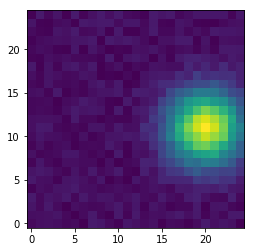

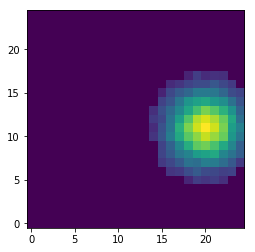

1


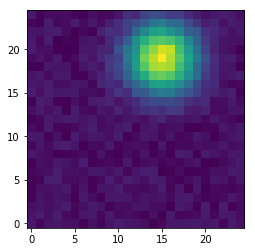

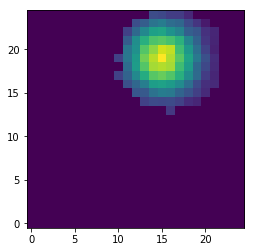

2


In [11]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
count=0
for i in range(len(y_pred)):
  if(i%624==0 and i<624*2):
    plt.imshow(test_image[count],origin='lower')
    plt.show()
    final = np.array(y_pred[i:i+625])
    final=final.reshape(25,25)
    for x in range(len(final)):
      for y in range(len(final[x])):
        if(final[x][y]==1):
          #final[x][y]=0
          final[x][y]=test_noise_image[count][x][y]
    plt.imshow(final,origin='lower')
    plt.show()
    count+=1
    print(count)

Training parameters are poor and the booster can be changed, DART booster to drop some of the trees. This is because there are more 0 when compared to 1. 


Next is when we have more than 1 cluster we can try for a multi-class classification with getting 

Idea 1 
* We can Use the BDT to form a clusterizer.
* This is a semi-automated work we can do in clusterising
* Generate photon shower (make sure there is only 1 shower ) along with dark Hits and Random bkg. Loo

# Modelling a dummy event in the BCAL, One step closer to real model
* Below is a simple model on how a clean  shower will look like in one of the modules in the bcal. 

trying to generate fully contained events in the BCAL

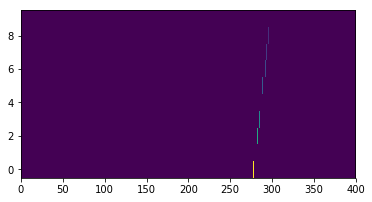

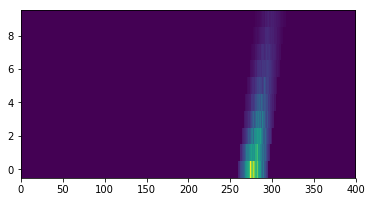

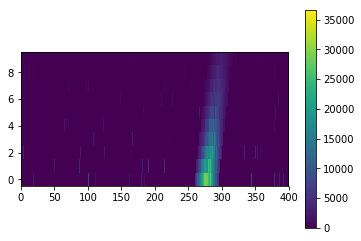

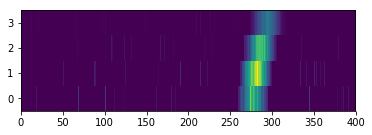

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import math
from skimage import feature


def par_gen():  # generates slope and intercept which 
  slope = rand.uniform(0,10)
  intercept = rand.randrange(0,400)
  final_hit = slope*9+intercept
  distance = math.sqrt((13*9)**2+final_hit**2)
  return final_hit,distance,slope,intercept

def event_gen(number_showers,Energy):
  bcal_r_z = np.zeros((10,400))
  final_hit=500
  distance=0
  while((final_hit>399 or final_hit<0)and(distance<13*9 or distance>415)):
    final_hit,distance,slope,intercept=par_gen()
  for i in range(len(bcal_r_z)):
    y = slope*i+intercept
    y=round(y)
    #y = int(y)
    bcal_r_z[i][y] = Energy*np.exp(-0.25*i) # This is how dE/dr of a photonic shower is modelled
    #print(y,i)
  return bcal_r_z


bcal = event_gen(1,15000)
plt.imshow(bcal,origin='lower',aspect=20)
plt.show()

def max_E_row(bcal_matrix):
  seed_E = np.max(bcal_matrix)
  return seed_E

def random_radius(min_size,max_size):
  rand_radius = rand.randrange(min_size,max_size)
  return rand_radius


def smear(bcal_matrix):
  temp_radius = random_radius(10,40)
  shift = rand.randint(temp_radius,temp_radius+5)
  #print("temp_radius",temp_radius)
  for i in range(len(bcal_matrix)):
    #temp_radius+=abs(i-10)
    seed_E = np.max(bcal_matrix[i])
    #print("Max energy",seed_E)
    y, = np.where(bcal_matrix[i]==seed_E)
    y = int(y)
    #y-=i*shift
    #print(y)
    left = y-temp_radius
    right = y+temp_radius
    for rad in range(left,right):
      #left = y+rad
      #right = y+rad
      if(rad>=0 and rad<len(bcal_matrix[i])):
        bcal_matrix[i][rad]=seed_E*np.exp(-0.5*(rad-y)**2/(temp_radius/2)**2) # this is how dE/dz of a photonic shower is modelled.
        bcal_matrix[i][rad]+=rand.gauss(bcal_matrix[i][rad],bcal_matrix[i][rad]/5)
  return bcal_matrix


bcal_smeared = smear(bcal)
plt.imshow(bcal_smeared,origin='lower',aspect=20)
plt.show()


def add_Noise_bcal(bcal_smeared):
  for i in range(len(bcal_smeared)):
    maxi = rand.randint(5,15)
    for s in range(0,maxi):
      j = rand.randint(0,400)
      seed_E = max_E_row(bcal_smeared[i])
      bcal_smeared[i][j]+=seed_E*rand.random()/5
  return bcal_smeared

bcal_noise = add_Noise_bcal(bcal_smeared)
plt.imshow(bcal_noise,origin='lower',aspect=20)
plt.colorbar()
plt.show()  


def combine_to_layer(bcal_noise):
  bcal_combined_layers = np.zeros((4,400))
  for i in range(len(bcal_noise)):
    if(i==0):
      bcal_combined_layers[0]+=bcal_noise[i]
    if(i>0 and i<3):
      bcal_combined_layers[1]+=bcal_noise[i]
    if(i>=3 and i<6):
      bcal_combined_layers[2]+=bcal_noise[i]
    if(i>=6 and i<10):
      bcal_combined_layers[3]+=bcal_noise[i]
  return bcal_combined_layers

bcal_final_layers = combine_to_layer(bcal_noise)
plt.imshow(bcal_final_layers,origin='lower',aspect=30)
plt.show()

These are irrelavant sections just to do some experimentation